# Preprocessing

Implement the preprocessing and justify the preprocessing steps

**Resize, grayscale & normalization**

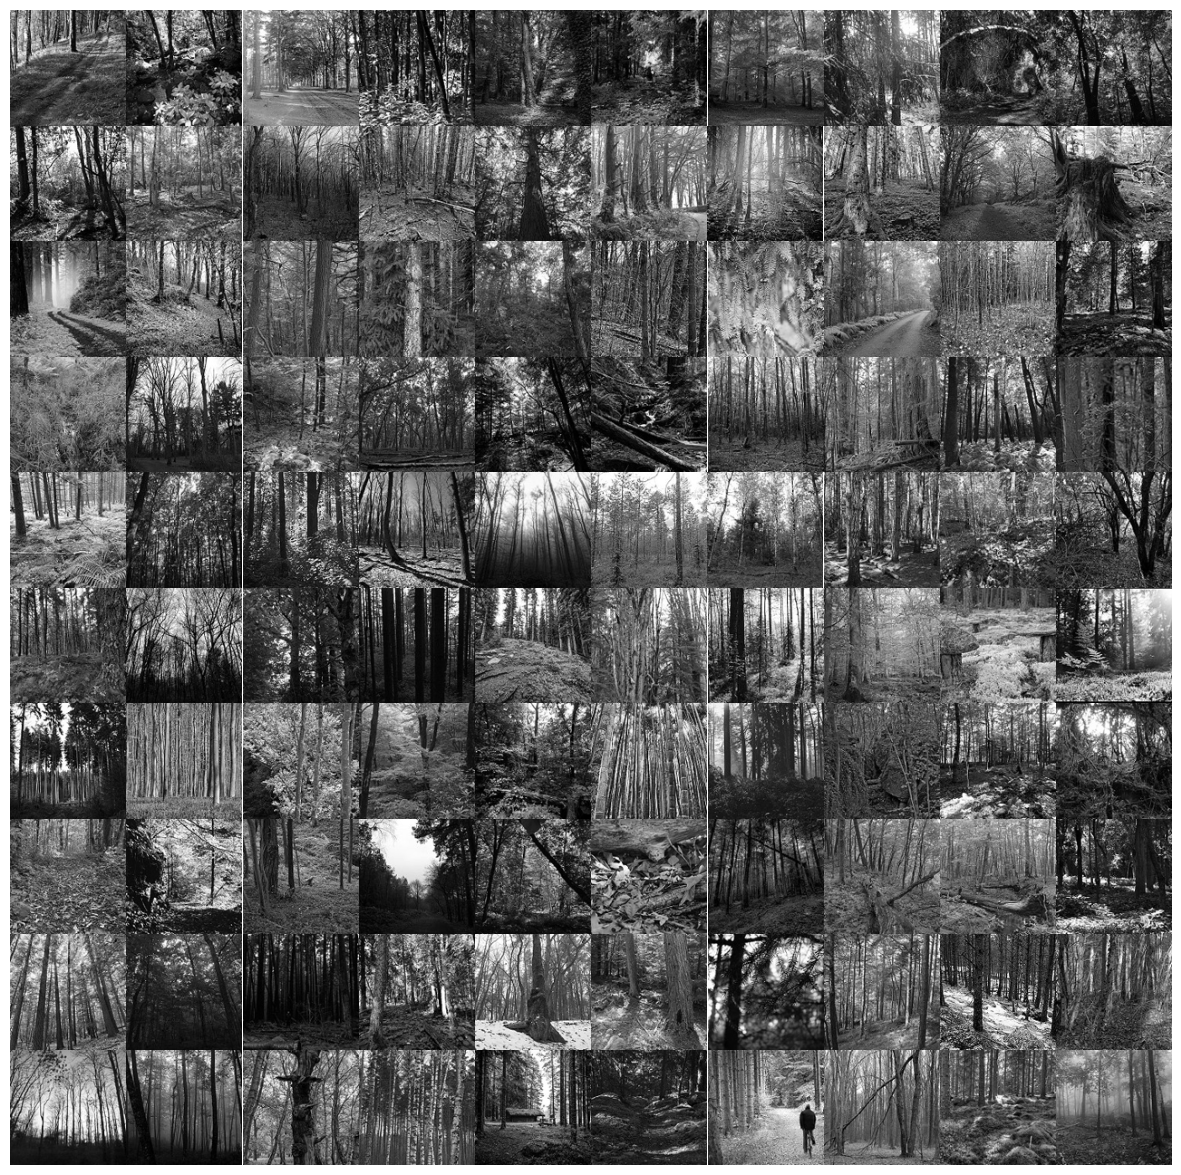

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to collect all images from a folder (including subfolders)
def collect_images_from_folder(folder_path):
    image_paths = []
    # Walk through all subfolders and gather image file paths
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Add conditions for image file types if necessary
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Function to preprocess the images (resize, grayscale, and normalize)
def preprocess_images(image_paths, image_size=(128, 128)):
    processed_images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize(image_size)  # Resize
        img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
        processed_images.append(img_array)
    return np.array(processed_images)


# Folder containing the images
folder_path = 'intel-image-classification'  # Update with your folder path

# Collect all image paths
image_paths = collect_images_from_folder(folder_path)

# Preprocess images
images = preprocess_images(image_paths)
# Display the first 100 preprocessed images
fig, axs = plt.subplots(10, 10, figsize=(15, 15), gridspec_kw={'wspace': 0, 'hspace': 0})

for i, ax in enumerate(axs.ravel()):
    if i < len(images[:100]):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


# Extract features

Extract features and justify the methods used 

**HOG**

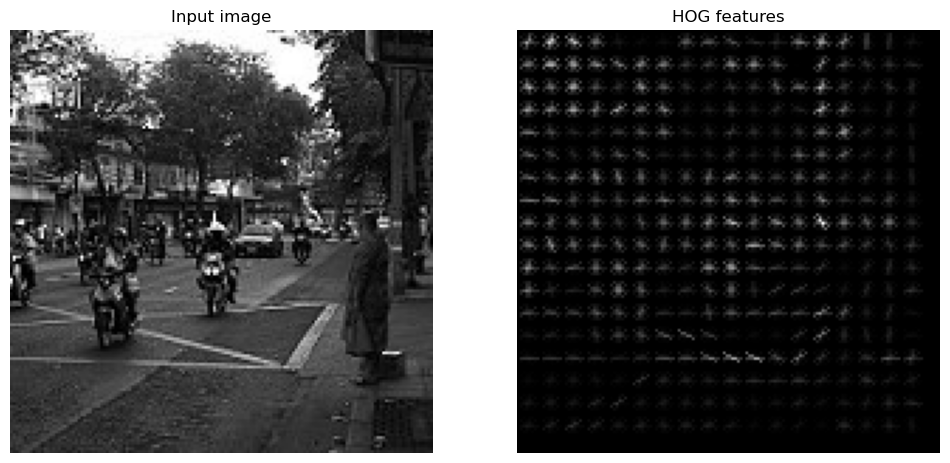

In [4]:
from skimage import feature, io, color
import matplotlib.pyplot as plt

# Load the image

image = io.imread('intel-image-classification/seg_pred/seg_pred/3.jpg')

# Convert the image to grayscale
#image = color.rgb2(image)

# Compute HOG features and the HOG image
hog_features, hog_image = feature.hog(image, 
                                      pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2),
                                      visualize=True,
                                      channel_axis=-1
                                      )

# Plot the original image and the HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('HOG features')

plt.show()

**PCA**

In [5]:
# Function to perform PCA on flattened images
from sklearn.decomposition import PCA



# Function to flatten images for PCA
def flatten_images(images):
    return np.array([img.flatten() for img in images])


def perform_pca(flattened_images, n_components=50):
    pca = PCA(n_components=n_components)
    # Fit PCA and transform the images
    transformed = pca.fit_transform(flattened_images)
    return transformed, pca

# Folder containing the images
folder_path = 'intel-image-classification'  # Update with your folder path

flattened_images = flatten_images(images)

# Perform PCA (without reconstruction)
transformed_images, pca_model = perform_pca(flattened_images, n_components=50)

KeyboardInterrupt: 